In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,StackingClassifier,ExtraTreesClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold

### Reading the Data

In [5]:
df=pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(df.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

## 1. EDA - Exploratory Data Analysis

### Checking for Null Values and Duplicates

In [6]:
print(df.columns)
print(df.shape)
print('duplicates = '+str(df.duplicated().sum()))
print(df.isnull().sum())

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')
(7043, 21)
duplicates = 0
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


There are 7043 rows and 21 columns, no null values and no duplicates.

### Checking the Balance of Dataset

In [7]:
df['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

The class is highly imbalanced, data of the churn 'Yes' needs to be oversampled.

### Univariate analysis

#### Categorical Columns

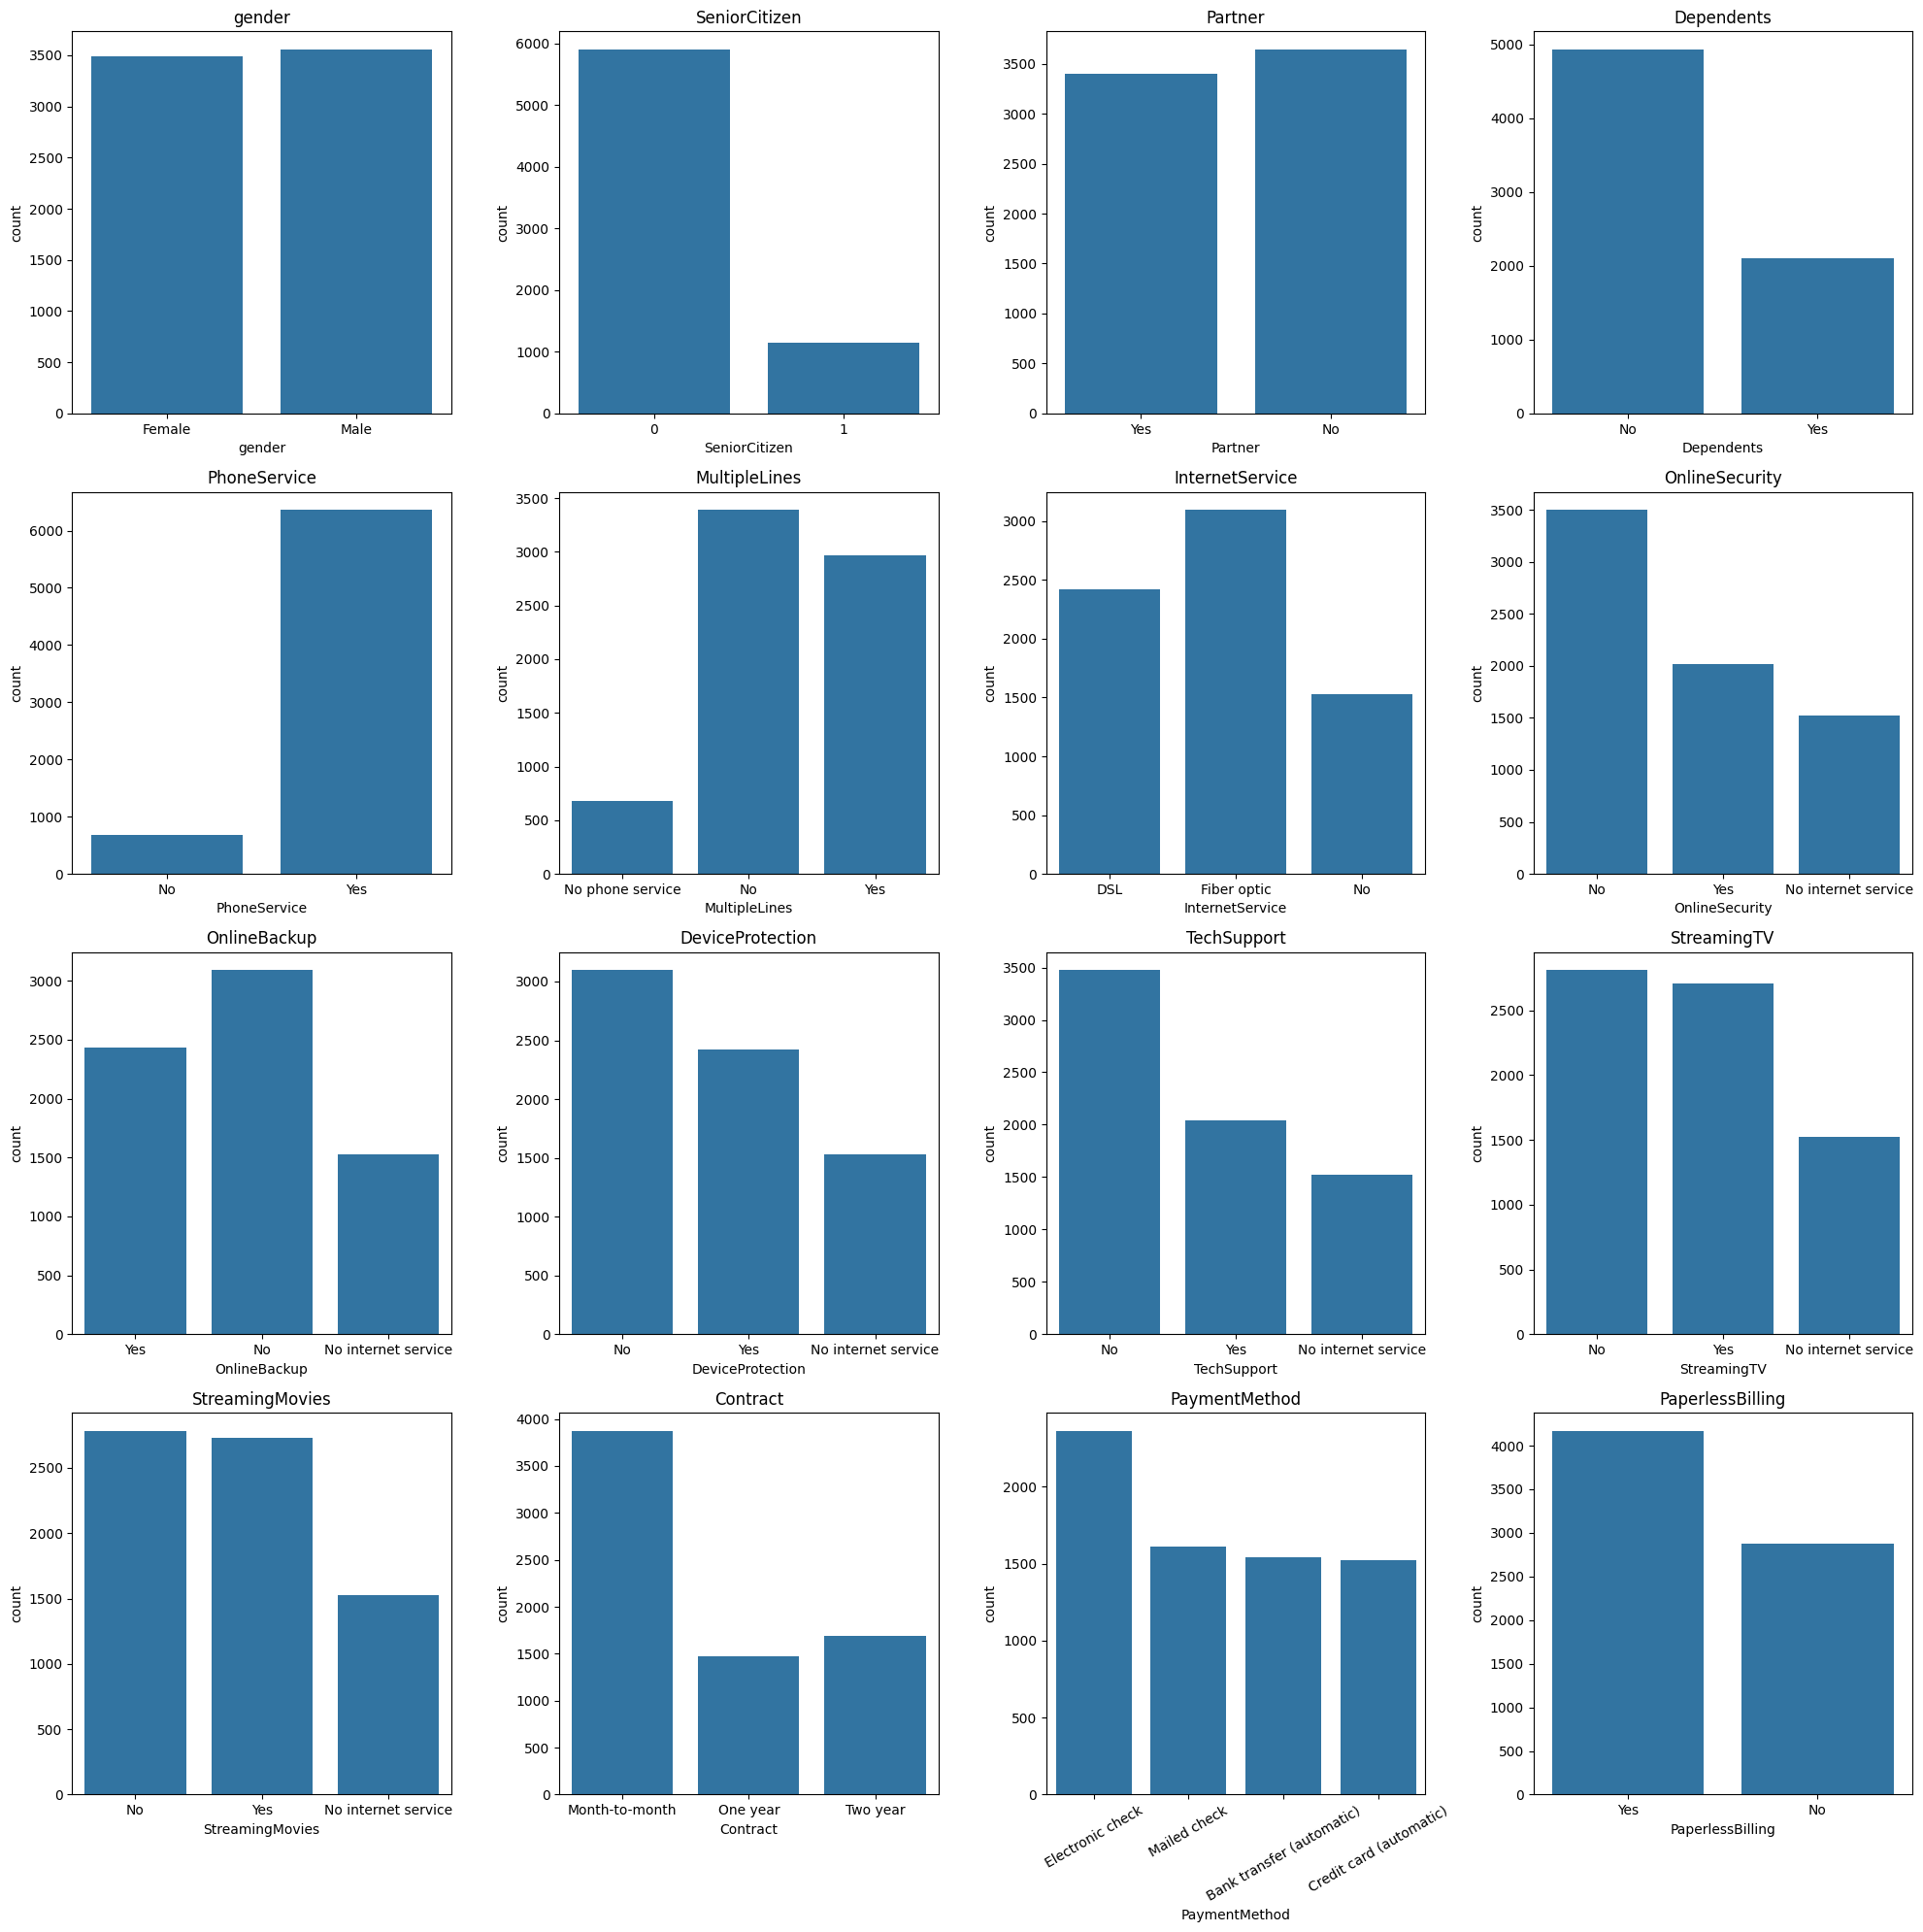

In [8]:
cols=['gender','SeniorCitizen','Partner','Dependents','PhoneService',
    'MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
    'DeviceProtection','TechSupport','StreamingTV','StreamingMovies',
    'Contract','PaymentMethod','PaperlessBilling']
fig, axes=plt.subplots(4,4, figsize=(20,20))
axes=axes.flatten()
for i, col in enumerate(cols):
    sns.countplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f'{col}')
    axes[14].tick_params(axis='x',rotation=30)
plt.tight_layout()

###### > Gender, Partner columns are balanced
###### > There are less number of senior citizens
###### > The are lesser number of dependents and those with no phone service
###### > There are less multiple lines users among those who have phone service.
###### > More people opted for fibre optic than DSL and around 20~23% people with no internet service.
###### > Many of those who have internet serviceve online security and online backup, device protection and tech support.
###### > There is insignificant difference between those who stream tv/movies and those who doesn't. (Need not be considered further)
###### > Many customers have optep for month-to-month contract and surprisingly customers opted for two-year contract are a bit more than those who opted for one-year contract.
###### > Many customers make paper less billing and by electronic check.


#### Numerical Columns

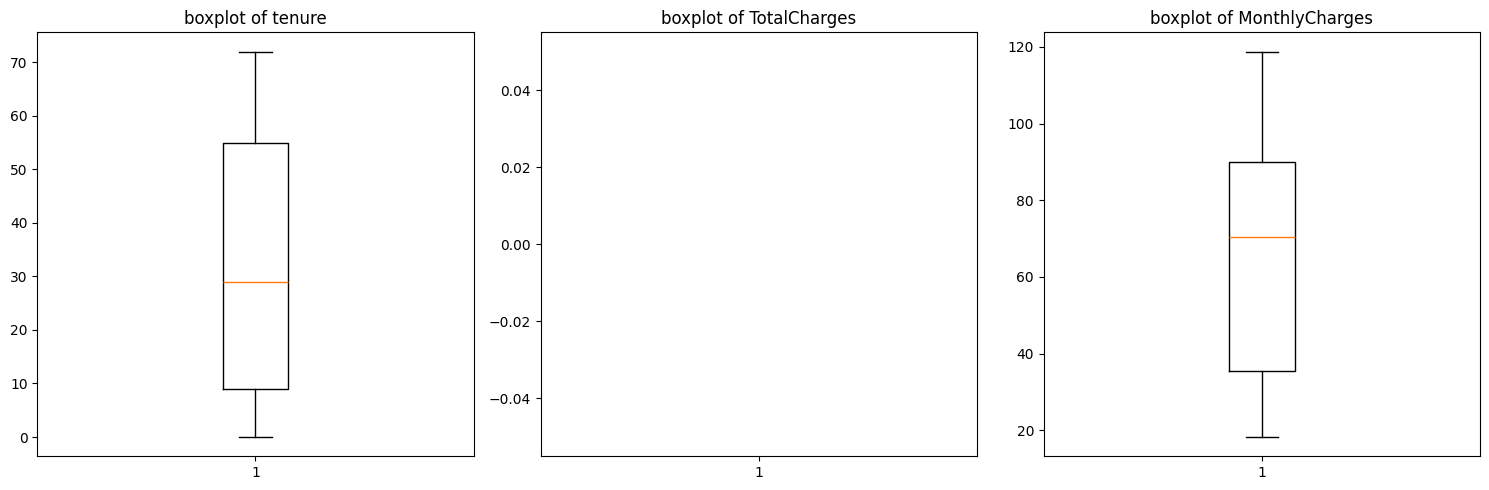

In [9]:

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')


cols=['tenure','TotalCharges','MonthlyCharges']
fig, axes=plt.subplots(1,3, figsize=(15,5))
axes=axes.flatten()
for i, col in enumerate(cols):
    axes[i].boxplot(df[col])
    axes[i].set_title(f'boxplot of {col}')
plt.tight_layout()

###### The total Charges data is highly right skewed, there are few customers whose total charges are extremely high compared to the average. While tenure and monthly charges are a bit right skewed too, it doesn't significantly make any difference.

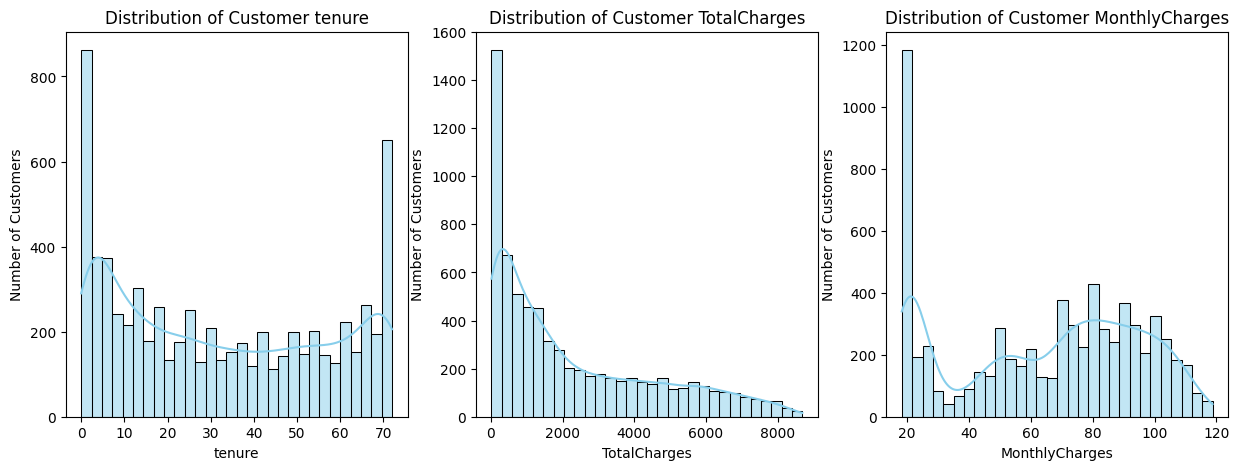

In [10]:

cols=['tenure','TotalCharges','MonthlyCharges']
fig, axes=plt.subplots(1,3, figsize=(15,5))
axes=axes.flatten()
for i, col in enumerate(cols):
    sns.histplot(df[col], bins=30, kde=True, color='skyblue',ax=axes[i])
    axes[i].set_title(f"Distribution of Customer {col}")
    axes[i].set_xlabel(f"{col}")
    axes[i].set_ylabel("Number of Customers")

The tenure distribution shows that either customers are churning in the early days or retaining for so long. So the early days are very critical to retain the customers.

Many customers have negligible total charges while more customers pay monthly charges of either 10-20 or in between 70-100

### Bivariate Analysis

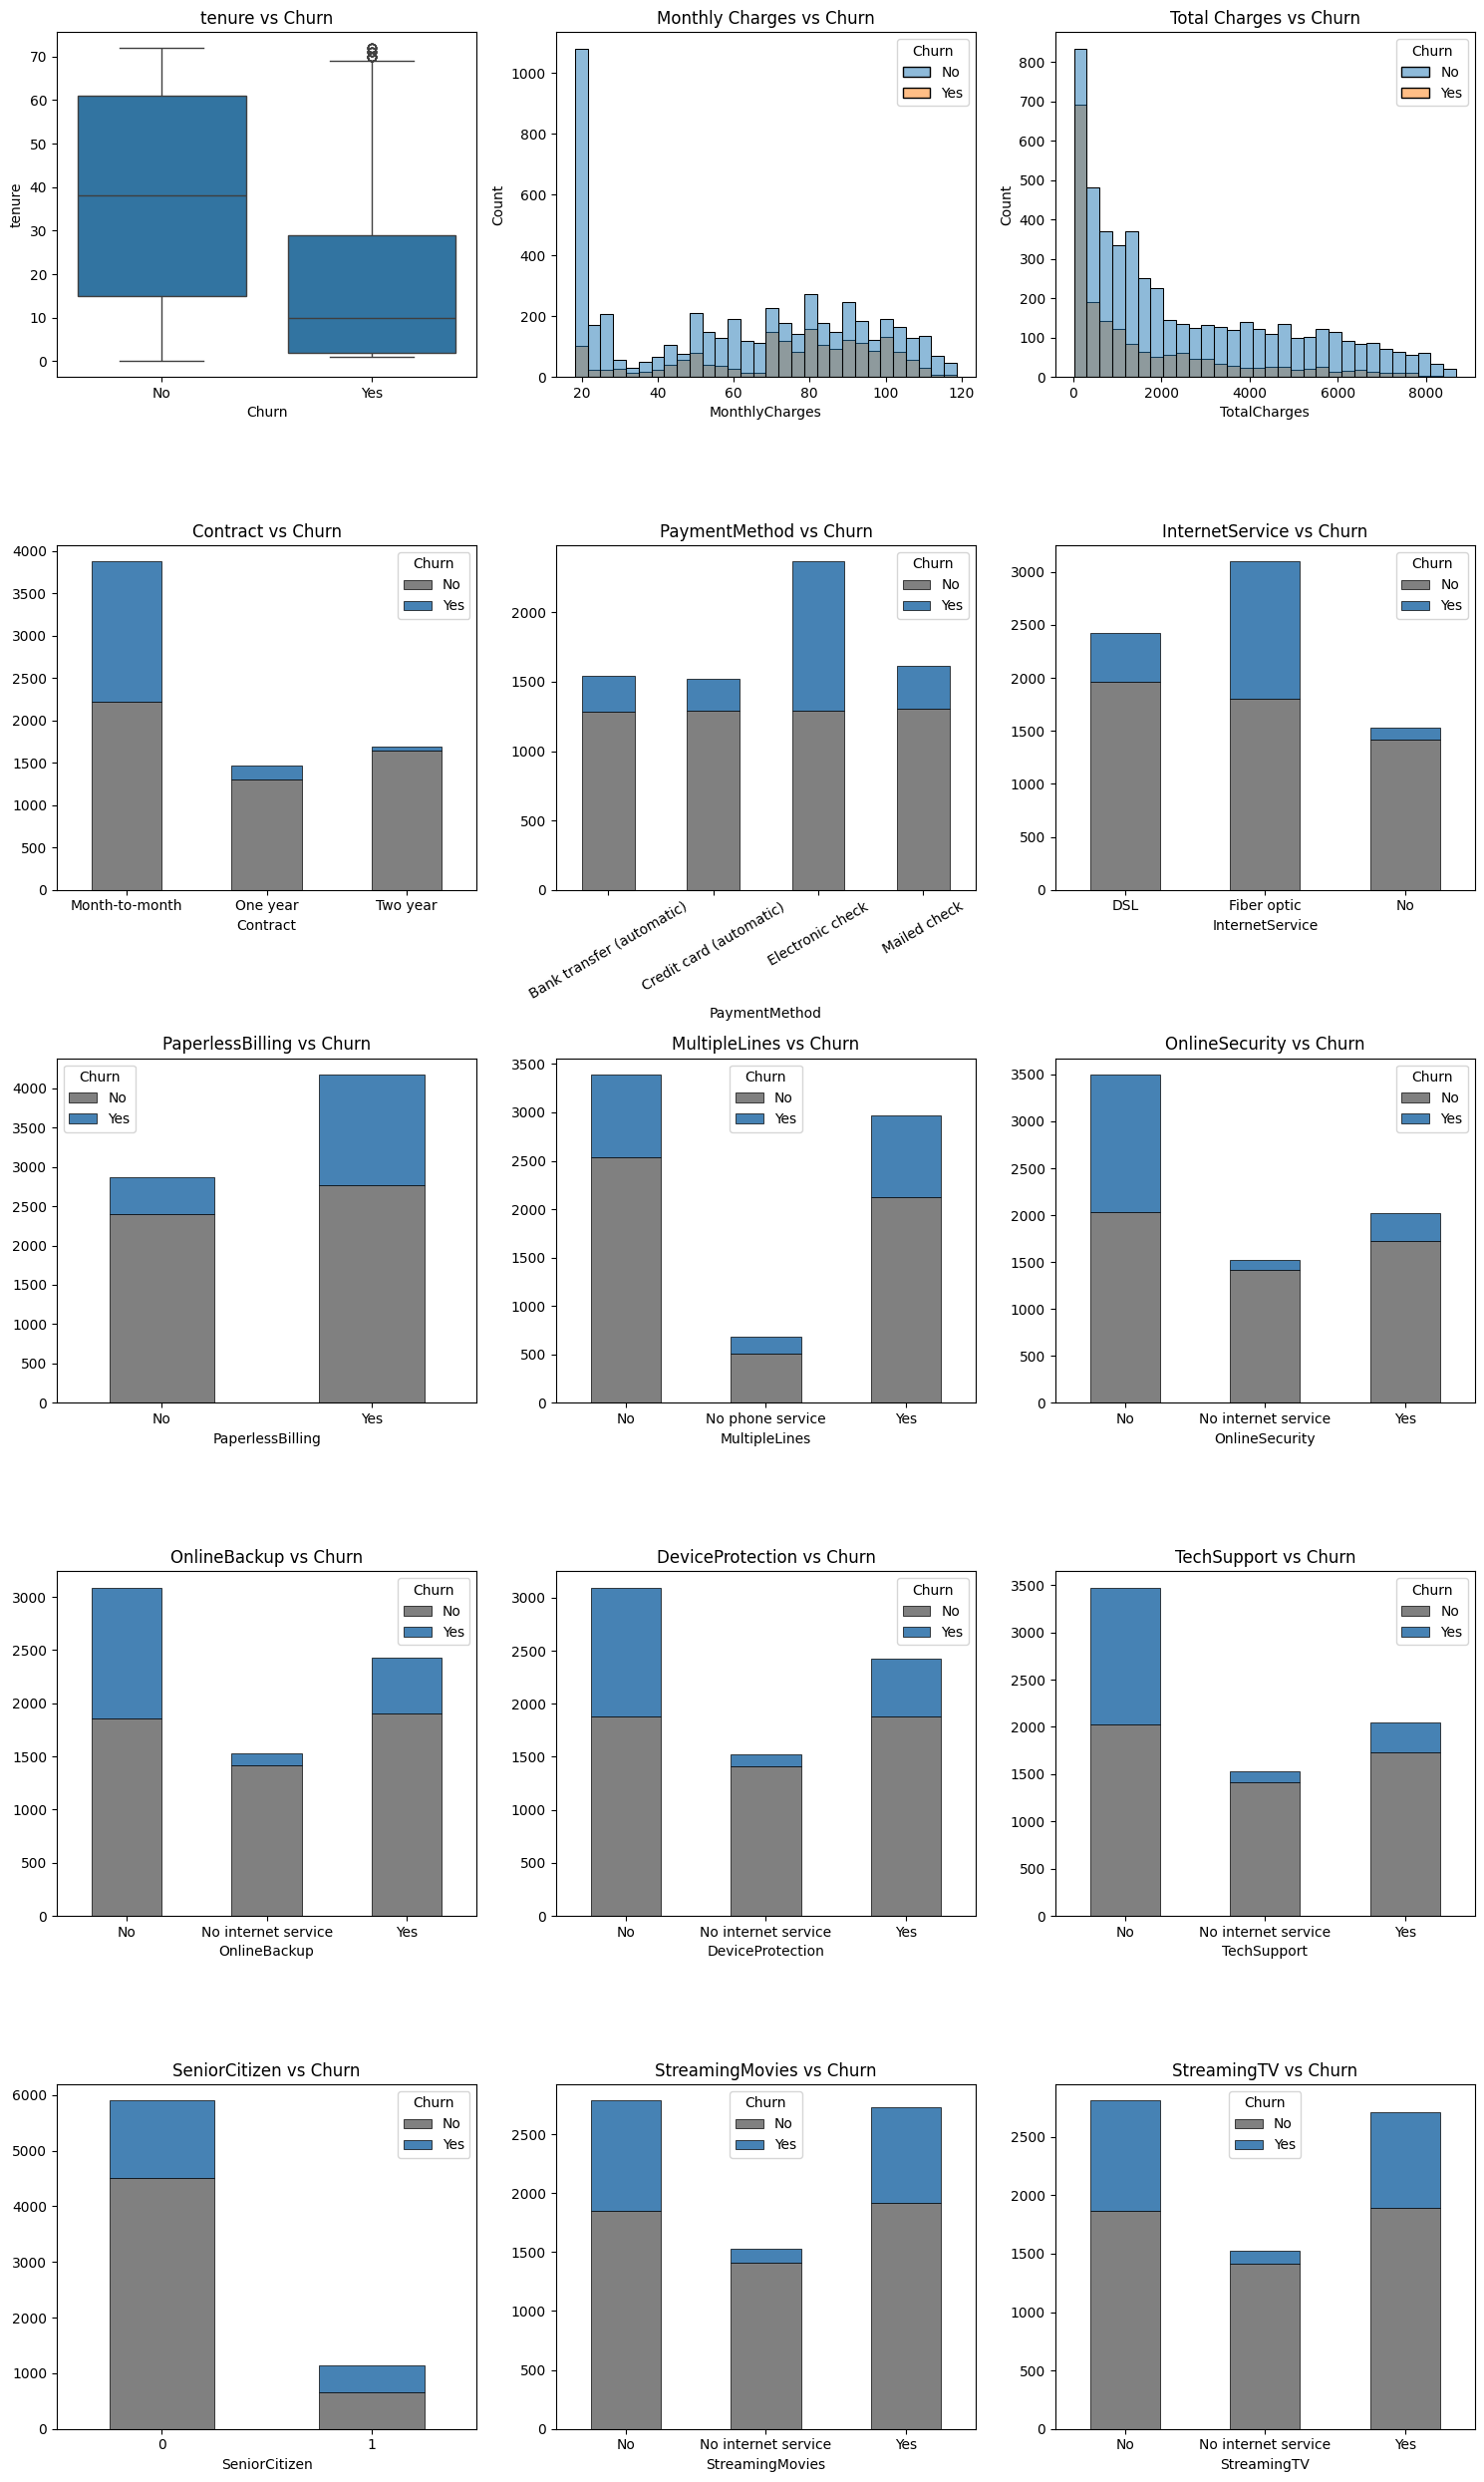

In [11]:
fig, ax =plt.subplots(5,3,figsize=(15,25))
ax=ax.flatten()
sns.boxplot(x='Churn',y='tenure',data=df,ax=ax[0])
ax[0].set_title('tenure vs Churn')
sns.histplot(data=df,x='MonthlyCharges',hue='Churn',bins=30,ax=ax[1]) #bins give number of data points on x-axis
ax[1].set_title('Monthly Charges vs Churn')
sns.histplot(data=df,x='TotalCharges',hue='Churn',bins=30,ax=ax[2]) #bins give number of data points on x-axis
ax[2].set_title('Total Charges vs Churn')

cols=['Contract','PaymentMethod','InternetService','PaperlessBilling','MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','SeniorCitizen', 'StreamingMovies','StreamingTV']
for i, col in enumerate(cols,3):
    pd.crosstab(df[col], df['Churn']).plot(kind='bar',stacked=True, color=['gray','steelblue'],ax=ax[i],edgecolor='black',linewidth=0.5)
    ax[i].set_title(f'{col} vs Churn')
    ax[i].tick_params(axis='x',rotation=0)
    ax[4].tick_params(axis='x',rotation=30)  
plt.tight_layout()

###### > People with low tenure and outlier tenures have high churn rate.
###### > Though monthly charges doesn't seem to have any relation with churn, as yearly charges reduces, churn rate is also reduced.
###### > It is also noticed that customers with one-contract and two-year contracts are less likely to churn than month-to-month contracts.
###### > More customers who use paper less billing and electronic check for payments churn more than those who use other methods.
###### > Though less in number 50% of senior citizens churn as compared to non-senior citizens(20%)
###### > It can be said that the people who use internet services, almost 50% of fibre optic users are likely to churn and also those who doesn't have online security, online backup, device protection, tech support are more likely to churn than the others. It shows how important cyber security is.

### Multivariate analysis

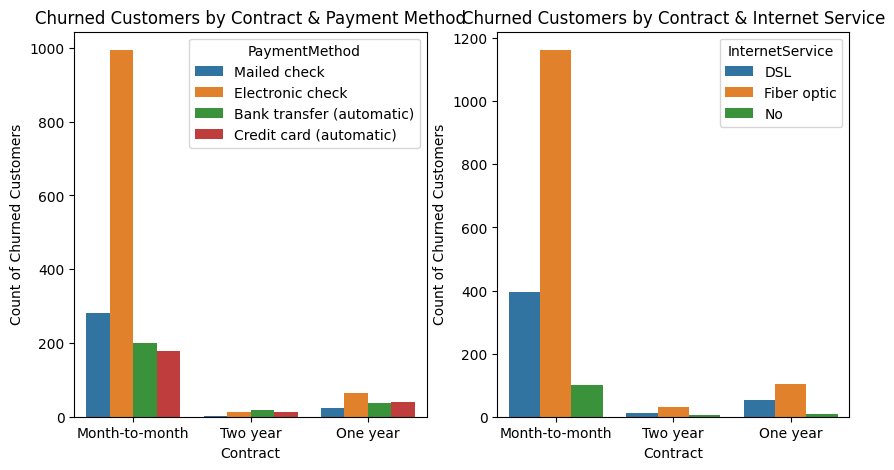

In [12]:
fig, ax=plt.subplots(1,2, figsize=(10,5))
sns.countplot(x='Contract', hue='PaymentMethod', data=df[df['Churn']=='Yes'],ax=ax[0])
ax[0].set_title("Churned Customers by Contract & Payment Method")
ax[0].set_ylabel("Count of Churned Customers")
sns.countplot(x='Contract', hue='InternetService', data=df[df['Churn']=='Yes'],ax=ax[1])
ax[1].set_title("Churned Customers by Contract & Internet Service")
ax[1].set_ylabel("Count of Churned Customers")
plt.show()

###### The churned customers those who opt for fibre optic and does the payment month-to-month by electronic check are very high in number.

In [13]:
df['Churn']=df['Churn'].map({'Yes':1,'No':0})

### Correlation Heatmap

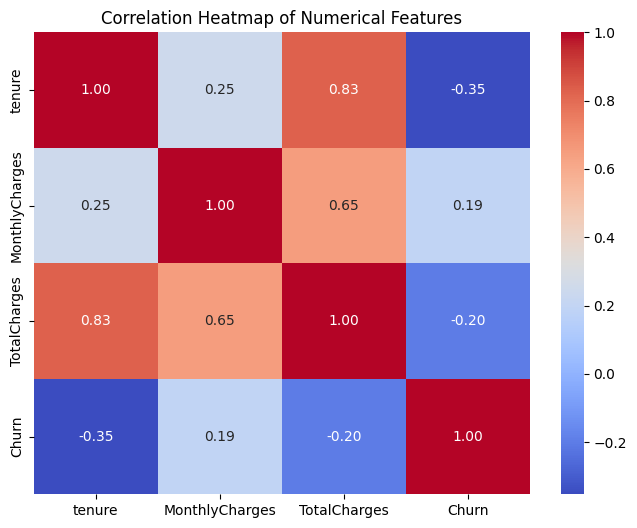

In [14]:
cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
cm = df[cols].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

###### >Only monthly charges have positive correlation with Churn, high monthly charges --> high churn (explainable).
###### >While total charges, and tenure have negative correlation. 
###### >This says, higher tenure --> lower churn showing loyalty of customers
###### >Also customers with high tenure means that they've stayed for very long, leading to high total charge that they paid all those months, so negative correlation of total charges with churn is explained. High total charge --> low churn

## 2. Preprocessing

Since the data of the column 'TotalCharges' is stored as a string, it is converted to numeric first, then we find the null values.

In [15]:
df['TotalCharges']=pd.to_numeric(df['TotalCharges'], errors='coerce')
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Filling the null values in the column TotalCharges

In [16]:
df['TotalCharges']=df['TotalCharges'].fillna(0)
df['Churn']=df['Churn'].fillna(0)
df=df.drop(['customerID'], axis=1)

#### Encoding categorical Values

Binary encoding for binary columns, and one hot encoding for more than 2 classes so that machine wont give priority order when we encode 0 1 2 as 0<1<2

In [17]:
#df['services_count'] = df[['PhoneService','MultipleLines','OnlineSecurity',
                           #'OnlineBackup','DeviceProtection','TechSupport',
                           #'StreamingTV','StreamingMovies']].apply(lambda x: sum(x=='Yes'), axis=1)
#df['tenure_bucket'] = pd.cut(df['tenure'], bins=[0,6,12,24,48,72], labels=False)
#df['avg_monthly'] = df['TotalCharges'] / df['tenure'].replace(0,1)

In [18]:
#cols = [ 'gender','Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

#for col in cols:
 #  df[col] = df[col].map({'Yes':1, 'No':0, 'Male':1, 'Female':0})

#df = pd.get_dummies(df, drop_first=True)

##### Removing zeroes to balance the data
Not a good option, since it's reducing the data

In [19]:
#n = 3305
#zero_indices = df[df['Churn'] == 0].index
#drop_indices = np.random.choice(zero_indices, n, replace=False)
#df = df.drop(drop_indices)
#df = df.reset_index(drop=True)

### Splitting the Data:

In [20]:
X = df.drop(['Churn'], axis=1)
X=X.fillna(0)
y = df['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
categorical_cols = [ 'gender','Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'InternetService', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
for col in categorical_cols:
    freq = X_train[col].value_counts(normalize=True)
    X_train[col] = X_train[col].map(freq)
    X_test[col] = X_test[col].map(freq)

From the boxplots in EDA, there are outliers in Total Charges, where it is expected, and these outliers are not removed, else we might lose the significant data.

### OverSampling
Since the classes of Churn (70:30) are highly imbalanced, we will use Synthetic Minority Oversampling Technique to balance the classes

In [22]:
#from imblearn.over_sampling import RandomOverSampler

#ros = RandomOverSampler(random_state=42)
#X_train, y_train = ros.fit_resample(X_train, y_train)

### Data Standardization

To adjust the range of values of numeric columns, we standardize the data using standard scaler

In [23]:
scaler = StandardScaler()

X_train[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(X_train[['tenure', 'MonthlyCharges', 'TotalCharges']])
X_test[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.transform(X_test[['tenure', 'MonthlyCharges', 'TotalCharges']])

In [24]:
lr = LogisticRegression( random_state=42, class_weight='balanced')
lr.fit(X_train, y_train)

y_p_lr = lr.predict(X_test)
pr_lr = lr.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.01,0.99,99)
f1s = [f1_score(y_p_lr, (pr_lr>t).astype(int)) for t in thresholds]
best_t = thresholds[np.argmax(f1s)]
print("best threshold:", best_t, "best f1:", max(f1s))

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_p_lr))
print("F1 Score:", f1_score(y_test, y_p_lr))
print("ROC AUC:", roc_auc_score(y_test, pr_lr))
print("\nClassification Report:\n", classification_report(y_test, y_p_lr))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_p_lr))

best threshold: 0.5 best f1: 1.0
Logistic Regression
Accuracy: 0.7374024130589071
F1 Score: 0.6145833333333334
ROC AUC: 0.8420599860497558

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.79      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409


Confusion Matrix:
 [[744 291]
 [ 79 295]]


In [25]:
rf = RandomForestClassifier(n_estimators=165, random_state=42,class_weight='balanced')

rf.fit(X_train, y_train)

y_p_rf = rf.predict(X_test)
pr_rf = rf.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.01,0.99,99)
f1s = [f1_score(y_p_rf, (pr_rf>t).astype(int)) for t in thresholds]
best_t = thresholds[np.argmax(f1s)]
print("best threshold:", best_t, "best f1:", max(f1s))

print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_p_rf))
print("F1 Score:", f1_score(y_test, y_p_rf))
print("ROC AUC:", roc_auc_score(y_test, pr_rf))
print("\nClassification Report:\n", classification_report(y_test, y_p_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_p_rf))


best threshold: 0.5 best f1: 1.0
Random Forest
Accuracy: 0.7927608232789212
F1 Score: 0.5602409638554217
ROC AUC: 0.8233240331705806

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.64      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409


Confusion Matrix:
 [[931 104]
 [188 186]]


In [26]:
xgbc = xgb.XGBClassifier(scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
                         eval_metric='logloss', random_state=42,enable_categorical=True)

xgbc.fit(X_train, y_train)

y_p_xgb = xgbc.predict(X_test)
pr_xgb = xgbc.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.01,0.99,99)
f1s = [f1_score(y_p_xgb, (pr_xgb>t).astype(int)) for t in thresholds]
best_t = thresholds[np.argmax(f1s)]
print("best threshold:", best_t, "best f1:", max(f1s))

print("XGBoost ")
print("Accuracy:", accuracy_score(y_test, y_p_xgb))
print("F1 Score:", f1_score(y_test, y_p_xgb))
print("ROC AUC:", roc_auc_score(y_test, pr_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_p_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_p_xgb))

    

best threshold: 0.5 best f1: 1.0
XGBoost 
Accuracy: 0.7558552164655784
F1 Score: 0.5914489311163895
ROC AUC: 0.8229907773386035

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.79      0.83      1035
           1       0.53      0.67      0.59       374

    accuracy                           0.76      1409
   macro avg       0.70      0.73      0.71      1409
weighted avg       0.78      0.76      0.76      1409


Confusion Matrix:
 [[816 219]
 [125 249]]


In [27]:
lgb_model = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    class_weight='balanced', 
    random_state=42
)
lgb_model.fit(X_train, y_train)

# Predictions
y_p_lg = lgb_model.predict(X_test)
pr_lg = lgb_model.predict_proba(X_test)[:,1]

# Metrics
print("LightGBM Accuracy:", accuracy_score(y_test, y_p_lg))
print("LightGBM F1 Score:", f1_score(y_test, y_p_lg))
print("LightGBM ROC AUC:", roc_auc_score(y_test, pr_lg))

[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LightGBM Accuracy: 0.7679205110007097
LightGBM F1 Score: 0.5947955390334573
LightGBM ROC AUC: 0.8163372859025033


In [28]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    verbose=100,
    class_weights=[1, 3]  # adjust weight for churn class
)

cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)

y_p_cat = cat_model.predict(X_test)
pr_cat = cat_model.predict_proba(X_test)[:,1]

print("CatBoost Accuracy:", accuracy_score(y_test, y_p_cat))
print("CatBoost F1 Score:", f1_score(y_test, y_p_cat))
print("CatBoost ROC AUC:", roc_auc_score(y_test, pr_cat))

0:	test: 0.8196272	best: 0.8196272 (0)	total: 145ms	remaining: 2m 24s
100:	test: 0.8441306	best: 0.8446317 (98)	total: 493ms	remaining: 4.39s
200:	test: 0.8421272	best: 0.8446317 (98)	total: 853ms	remaining: 3.39s
300:	test: 0.8425857	best: 0.8446317 (98)	total: 1.22s	remaining: 2.84s
400:	test: 0.8386564	best: 0.8446317 (98)	total: 1.56s	remaining: 2.33s
500:	test: 0.8374215	best: 0.8446317 (98)	total: 1.93s	remaining: 1.92s
600:	test: 0.8355615	best: 0.8446317 (98)	total: 2.32s	remaining: 1.54s
700:	test: 0.8330324	best: 0.8446317 (98)	total: 2.73s	remaining: 1.16s
800:	test: 0.8312653	best: 0.8446317 (98)	total: 3.07s	remaining: 763ms
900:	test: 0.8291651	best: 0.8446317 (98)	total: 3.39s	remaining: 373ms
999:	test: 0.8274006	best: 0.8446317 (98)	total: 3.74s	remaining: 0us

bestTest = 0.8446317394
bestIteration = 98

Shrink model to first 99 iterations.
CatBoost Accuracy: 0.7409510290986515
CatBoost F1 Score: 0.6248715313463515
CatBoost ROC AUC: 0.8446317393887726


In [29]:

estimators = [
    ('rf', RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=5, random_state=42,class_weight='balanced')),
    ('lgb', LGBMClassifier(n_estimators=700, learning_rate=0.05, num_leaves=31, random_state=42,class_weight='balanced')),
    ('et', ExtraTreesClassifier(n_estimators=300, max_depth=12, min_samples_leaf=5, random_state=42,class_weight='balanced'))
]

# Final estimator (meta-model)
final_estimator = LogisticRegression(C=1.0, max_iter=1000)

# Stacking classifier with stratified CV
stack= StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    passthrough=True  # Pass original features to meta-model
)

stack.fit(X_train, y_train)

y_p_st = stack.predict(X_test)
pr_st = stack.predict_proba(X_test)[:,1]

print("Stacking Accuracy:", accuracy_score(y_test, y_p_st))
print("Stacking F1 Score:", f1_score(y_test, y_p_st))
print("Stacking ROC AUC:", roc_auc_score(y_test, pr_st))

# Optional: Threshold tuning for best F1
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_test, (pr_st > t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
print("Best Threshold for F1:", best_threshold)

# Apply best threshold
y_pred_best = (pr_st > best_threshold).astype(int)
print("Stacking F1 Score (tuned threshold):", f1_score(y_test, y_pred_best))


Stacking Accuracy: 0.8041163946061036
Stacking F1 Score: 0.6068376068376068
Stacking ROC AUC: 0.8458782195355085
Best Threshold for F1: 0.2799999999999999
Stacking F1 Score (tuned threshold): 0.64340239912759


In [31]:
from sklearn.model_selection import cross_val_score
cv=cross_val_score(stack, X_train, y_train, cv=5, scoring='f1').mean()
print(float(cv))

0.6029943688413619


In [32]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'Stacking(rf,lgb,et ->lr)', 'Lightboost', 'Catboost'],
    'Accuracy': [
        accuracy_score(y_test, y_p_lr),
        accuracy_score(y_test, y_p_rf),
        accuracy_score(y_test, y_p_xgb),
        accuracy_score(y_test, y_p_st),
        accuracy_score(y_test, y_p_lg),
        accuracy_score(y_test, y_p_cat)
    ],
    'F1 Score': [
        f1_score(y_test, y_p_lr),
        f1_score(y_test, y_p_rf),
        f1_score(y_test, y_p_xgb),
        f1_score(y_test, y_pred_best),
        f1_score(y_test, y_p_lg),
        f1_score(y_test, y_p_cat)        
    ],
    'ROC AUC': [
        roc_auc_score(y_test, pr_lr),
        roc_auc_score(y_test, pr_rf),
        roc_auc_score(y_test, pr_xgb),
        roc_auc_score(y_test, pr_st),
        roc_auc_score(y_test, pr_lg),
        roc_auc_score(y_test, pr_cat)
    ]
})

results

,Model,Accuracy,F1 Score,ROC AUC
0,Logistic Regression,0.737402,0.614583,0.842060
1,Random Forest,0.792761,0.560241,0.823324
2,XGBoost,0.755855,0.591449,0.822991
3,"Stacking(rf,lgb,et ->lr)",0.804116,0.643402,0.845878
4,Lightboost,0.767921,0.594796,0.816337
5,Catboost,0.740951,0.624872,0.844632


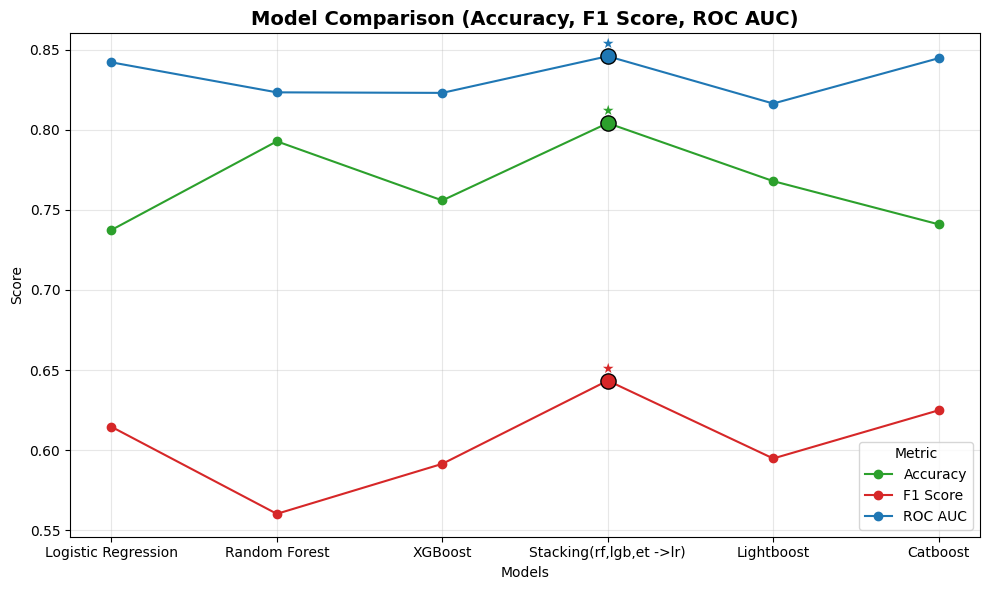

In [33]:
import matplotlib.pyplot as plt

# Melt dataframe
results_melted = results.melt(id_vars='Model', 
                              value_vars=['Accuracy', 'F1 Score', 'ROC AUC'],
                              var_name='Metric', value_name='Score')

plt.figure(figsize=(10,6))

# Define consistent colors for each metric
metric_colors = {
    'Accuracy': '#2ca02c',    # green
    'F1 Score': '#d62728',    # red
    'ROC AUC': '#1f77b4'      # blue
}

# Plot each metric with its matching color
for metric, color in metric_colors.items():
    subset = results_melted[results_melted['Metric'] == metric]
    plt.plot(subset['Model'], subset['Score'], marker='o', color=color, label=metric)

# Identify best models
best_acc_idx = results['Accuracy'].idxmax()
best_f1_idx = results['F1 Score'].idxmax()
best_roc_idx = results['ROC AUC'].idxmax()

# Mark best Accuracy
plt.scatter(results.loc[best_acc_idx, 'Model'], results.loc[best_acc_idx, 'Accuracy'],
            color=metric_colors['Accuracy'], s=120, edgecolor='black', zorder=5)
plt.text(results.loc[best_acc_idx, 'Model'], results.loc[best_acc_idx, 'Accuracy'] + 0.005,
         '★',
         color=metric_colors['Accuracy'], ha='center', fontweight='bold')

# Mark best F1 Score
plt.scatter(results.loc[best_f1_idx, 'Model'], results.loc[best_f1_idx, 'F1 Score'],
            color=metric_colors['F1 Score'], s=120, edgecolor='black', zorder=5)
plt.text(results.loc[best_f1_idx, 'Model'], results.loc[best_f1_idx, 'F1 Score'] + 0.005,         '★',
         color=metric_colors['F1 Score'], ha='center', fontweight='bold')

# Mark best ROC AUC
plt.scatter(results.loc[best_roc_idx, 'Model'], results.loc[best_roc_idx, 'ROC AUC'],
            color=metric_colors['ROC AUC'], s=120, edgecolor='black', zorder=5)
plt.text(results.loc[best_roc_idx, 'Model'], results.loc[best_roc_idx, 'ROC AUC'] + 0.005,         '★',
         color=metric_colors['ROC AUC'], ha='center', fontweight='bold')

# Formatting
plt.title('Model Comparison (Accuracy, F1 Score, ROC AUC)', fontsize=14, fontweight='bold')
plt.xlabel('Models')
plt.ylabel('Score')
plt.grid(alpha=0.3)
plt.legend(title='Metric')
plt.xticks(rotation=0, ha='center')
plt.tight_layout()
plt.show()


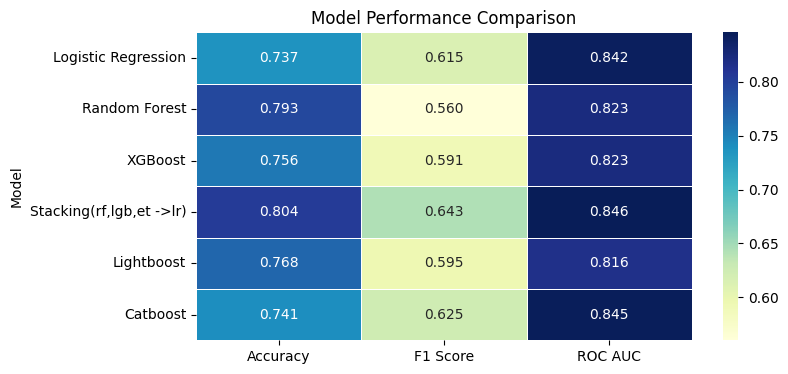

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.heatmap(results.set_index('Model'), annot=True, cmap='YlGnBu', fmt=".3f", linewidths=0.5)
plt.title("Model Performance Comparison")
plt.show()


### Upon Various Trials, Stacking Ensemble (LR, RF, LGB, ET) with Logistic Regression as Meta-Model and Threshold Tuning as the best model, with accuracy 80.41% and 64.34% F1score (tuned).

###### The results of trials are as follows:

###### Binary and one-hot encoding:
###### Logistic Regression	0.806246	0.604920	0.842171
###### Model			    Accuracy	F1 Score	ROC AUC
###### Random Forest		0.790632	0.557721	0.824165
###### XGBoost			    0.768630	0.609113	0.821064
###### Stacking(rf,lg,et)	0.801987	0.603129	0.846493
###### Lightboost		    0.774308	0.603491	0.821416
###### Catboost		    0.738822	0.626775	0.847926

###### Frequency encoding:
###### Model			    Accuracy	F1 Score	ROC AUC
###### Logistic Regression	0.804116	0.596491	0.842091
###### Random Forest		0.784954	0.551111	0.822407
###### XGBoost			    0.755855	0.591449	0.822991
###### Stacking(rf,lg,et)	0.804116	0.606838	0.845878
###### Lightboost		    0.767921	0.594796	0.816337
###### Catboost		    0.740951	0.624872	0.844632

###### Binary and one-hot encoding + Scaling:
###### Model			    Accuracy	F1 Score	ROC AUC
###### Logistic Regression	0.806955	0.609195	0.841778
###### Random Forest		0.790632	0.557721	0.824165
###### XGBoost			    0.768630	0.609113	0.821064
###### Stacking(rf,lg,et)	0.800568	0.602546	0.846170
###### Lightboost		    0.774308	0.603491	0.821427
###### Catboost		    0.738822	0.626775	0.847926

###### Frequency encoding + Scaling:
###### Model			    Accuracy	F1 Score	ROC AUC
###### Logistic Regression	0.803407	0.601439	0.841404
###### Random Forest		0.784954	0.551111	0.822407
###### XGBoost			    0.755855	0.591449	0.822991
###### Stacking(rf,lg,et)	0.801987	0.600858	0.844842
###### Lightboost		    0.772179	0.601242	0.817923
###### Catboost		        0.740951	0.624872	0.844632
